In [1]:
# import all necessary packages for analysis
import xarray as xr
from netCDF4 import Dataset, num2date
import numpy as np
import pandas as pd
from scipy import stats
from eofs.standard import Eof as EOF

### Part 1
- Calculate the DJF seasonal mean sea-level pressure (MSLP) from 1979-2016 from monthly mean data over the Atlantic sector. 
- Our analysis will utilize monthly mean fields extracted from the NCAR Reanalysis 2 at a 2.5 x 2.5 degree grid resolution. 

In [2]:
# input data directory
PATH = ''

In [3]:
# defining spatial and temporal domain of analysis
lati1 = 80
lati2 = 20
loni1 = 360-90
loni2 = 40

nyr = (2016-1979)
yrs = np.arange(1979, 2017, 1).astype(str)
nmon = 12

In [4]:
# read MSLP data and set variables
dat = xr.open_dataset(PATH+'mslp.mon.mean.nc')
lon0 = dat['lon'].values
lat0 = dat['lat'].values
time0 = dat['time']
mslp0 = dat['mslp']

nx0 = len(lon0)
ny0 = len(lat0)

In [5]:
# determine indices of lat/lon boundaries
i1 = np.argmin(abs(lon0-loni1))
i2 = np.argmin(abs(lon0-loni2))+1
j1 = np.argmin(abs(lat0-lati1))
j2 = np.argmin(abs(lat0-lati2))+1

In [6]:
# define lat/lon arrays over analysis region
lon1 = np.concatenate((lon0[i1:], lon0[:i2]))
lat1 = lat0[j1:j2]

nx1 = len(lon1)
ny1 = len(lat1)

# similarly for the MSLP variable
mslp1 = mslp0.sel(lat=lat1, lon=lon1)

In [7]:
# create time dimension defined once per year
time1 = pd.date_range(start=yrs[0]+'-01-01', end=yrs[-1]+'-01-01', freq='1Y')

To ensure that factors such as the seasonal cycle or external forcing (i.e., long-term trends) do not interfere with the EOF analysis, the anomalous MSLP field will be deseasonalized, detrended, and standardized prior to the analysis. 

In [8]:
# compute anomalies
mslp_a = mslp1 - mslp1.mean(dim='time')

# deseasonalizing function
def deseasonalize(var_a):
    months = var_a.time.dt.month
    clim = var_a.groupby(months).mean(dim='time')
    var_as = (var_a.groupby(months) - clim)
    return  var_as, months

In [9]:
# detrending function
def detrend_dim(var_as, dim, deg=1):
    # detrend along a single dimension
    p = var_as.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(var_as[dim], p.polyfit_coefficients)
    var_asd = var_as - fit
    return var_asd

In [10]:
# standardizing function
def standardize(var_asd, months):
    clim_mn = var_asd.groupby(months).mean('time')
    clim_std = var_asd.groupby(months).std('time')

    var_asds = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
                              var_asd.groupby(months), clim_mn, clim_std)
    return var_asds

In [11]:
# compute seasonal mean
def seasonal_mn(var_asds):
    # initialize empty data array
    var_seasmn = xr.DataArray(np.zeros((nyr, 
                                        len(var_asds.coords['lat'].values), 
                                        len(var_asds.coords['lon'].values))),
                              dims = ['time', 'lat', 'lon'],
                              coords = {'time': time1,
                                        'lat': var_asds.coords['lat'].values,
                                        'lon': var_asds.coords['lon'].values},)
    # loop through each year and compute DJF mean
    for yr in range(nyr):
        var_seasmn[yr,:,:] = var_asds[(yr*12)+11:(yr*12)+14,:,:].mean(dim='time')
    return var_seasmn

In [12]:
# wrap these functions into a preprocessing function
def preprocess_mon(var_a):
    var_as, months = deseasonalize(var_a)
    var_asd = detrend_dim(var_as, 'time', 1)
    var_asds = standardize(var_asd, months)
    var_seasmn = seasonal_mn(var_asds)
    return var_seasmn

# find the monthly mean detrended, deseasonalized, and standardized MSLP anomalies averaged over DJF
mslp_seasmn = preprocess_mon(mslp_a)

### Part(s) 2, 3, & 4: 
- Extract the first two EOFs and the corresponding principal component time series. 
- Plot the first two EOFs and the normalized principal component time series. Which modes of climate variability are represented by the two leading EOF patterns?  
- Plot the fractional variance of the first 10 EOFs. Is there a point at which the EOFs stop being physically and statistically meaningful, and why?

In [13]:
# applying a cosine-weighting to the MSLP anomalies
lons, lats = np.meshgrid(lon1, lat1)
wgts = np.sqrt(np.cos(np.deg2rad(lats)))

In [14]:
# solving for the EOFs and PCs
neofs = 2
solver = EOF(mslp_seasmn.to_numpy(), weights=wgts)

eofs1 = solver.eofsAsCorrelation(neofs=neofs)
pcs = solver.pcs(pcscaling=1, npcs=neofs)

var = solver.varianceFraction(neigs=10)

In [15]:
# define over the whole lat/lon domain for plotting purposes
eofs0 = np.zeros((neofs, ny0, nx0))
eofs0[:,j1:j2,i1:] = eofs1[:,:,:nx0-i1]
eofs0[:,j1:j2,:i2] = eofs1[:,:,nx0-i1:]

In [16]:
# import packages for plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point

In [17]:
# preparing plotting
crs = ccrs.PlateCarree()
projection = ccrs.PlateCarree()
cmap = plt.get_cmap('RdBu_r')

levels = np.arange(-1, 1.2, .2)

xticks = [-80, -60, -40, -20, 0, 20, 40, 60, 80]
yticks = [20, 40, 60, 80]

#adding cyclic boundary condition
eofs0, lon01 = add_cyclic_point(eofs0, lon0)

elabels = []
plabels = []
ind = np.arange(len(var))
for i in range(len(var)):
    elabels.append('EOF'+str(i+1))
    plabels.append('PC'+str(i+1))
    
def plot_background(ax):
    ax.add_feature(cfeature.COASTLINE)
    return ax

def plot_grid(ax):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), xlocs=xticks, ylocs=yticks, dms=True, linewidth=0.5, color='black', alpha=1, linestyle='-', draw_labels=True, y_inline=False, x_inline=False, ylim=80)
    gl.top_labels = False
    gl.right_labels= True
    gl.left_labels = False
    gl.bottom_labels = True
    gl.xlabel_style = {'color': 'black', 'rotation': 0, 'size': 10}
    gl.ylabel_style = {'color': 'black', 'rotation': 0, 'size': 10}
    return ax

<function matplotlib.pyplot.show(close=None, block=None)>

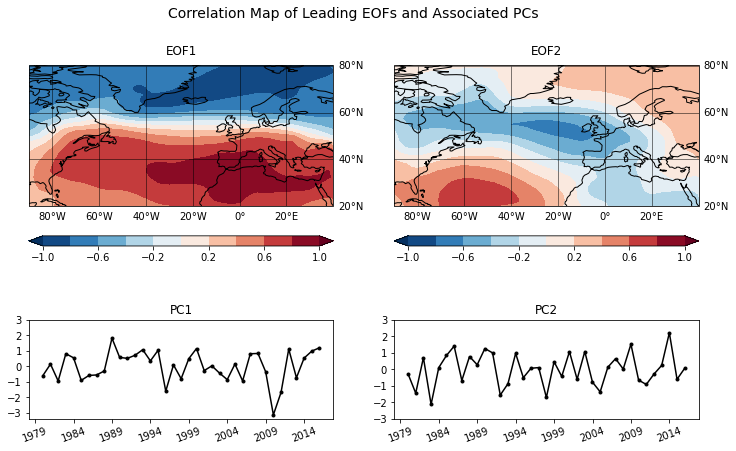

In [18]:
# plotting EOFs and PCs
fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(neofs, 2, height_ratios=[3,1])

fig.suptitle('Correlation Map of Leading EOFs and Associated PCs', fontsize=14, y=.84)

for k in range(neofs):
    ax = fig.add_subplot(gs[0,k], projection=projection)
    ax = plot_background(ax)
    ax.set_extent([loni1-360, loni2, lati1-12, lati2])
    cf = ax.contourf(lon01, lat0, eofs0[k,:,:], levels=levels, cmap=cmap, transform=crs, extend='both')
    ax = plot_grid(ax)
    cb = fig.colorbar(cf, ax=ax, location='bottom', orientation='horizontal', shrink=1, pad=0.1, aspect=30, ticks=cf.levels[::2])
    ax.set_title(elabels[k], fontsize=12)

    axx = fig.add_subplot(gs[1,k])
    pc, = axx.plot(time1, pcs[:,k], 'k.-')
    axx.set_yticks(np.arange(-3,4,1))
    axx.set_xticks(yrs[::5])
    axx.set_xticklabels(yrs[::5], rotation=20)
    axx.set_title(plabels[k], fontsize=12)
    
plt.show

The leading EOF modes represent the East Atlantic pattern and North Atlantic Oscillation, respectively. It might come as a suprise that the East Atlantic pattern emerges as the leading mode, but it is important to note that the relative prominence of the two modes is sensitive to the spatial and time domain of the analysis. More can be learned about this low-frequency mode of climate variability by following the link: https://www.cpc.ncep.noaa.gov/data/teledoc/ea.shtml

The NAO is clearly associated with a north-south dipole of MSLP anomalies, with one center near Greenland and the other center of opposite sign spanning the Central Atlantic between 20N and 40N. The positive phase of the NAO reflects anomalously low MSLP near the Greenland region and anomalously high MSLP over the Central Atlantic, while the negative phase reflects an opposite pattern of MSLP over these regions. 

<function matplotlib.pyplot.show(close=None, block=None)>

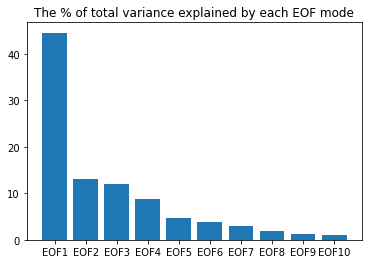

In [19]:
# plot fractional variance of the first 10 EOF modes
fig, ax = plt.subplots()
b = ax.bar(ind, var*100)
ax.set_xticks(ind, labels=elabels)
ax.set_title('The % of total variance explained by each EOF mode')

plt.show

The EOFs are derived by computing the eigenvectors and eigenvalues of the spatially-weighted anomaly covariance matrix of the MSLP field, such that the eigenvalues associated with each EOF mode provides a measure of the variance explained. The mathematical assumptions of EOF analysis, such as the orthogonality constraint, obscures the physical interpretation of the modes. Each mode cannot be interpreted as a teleconnection associated with a physical process nor can the possibility of the superposition of many different modes be ruled out. However, the "statistical significance" of the EOF modes can be evaluated using semi-objective techniques. Generally, the slope of the eigenvalue spectrum is analyzed (or in this case, the fractional variance) to identify a point in which successive modes are indistinguishable to choose the number of EOF modes to retain. This is similar to the elbow method used in cluster analysis. Otherwise, an objective constraint on the fractional variance can be utilized (e.g., 5% variance explained) to reject modes, but the choice of threshold is arbitrary. 

# Part 5 & 6:
- Reconstruct the SLP field the EOF mode associated with the NAO, then compute the correlation with the corresponding DJF seasonal mean precipitation and surface temperature anomalies (standardized, detrended, and deseasonalized).
- Comment on what this analysis teaches us about the relationship between the NAO and atmospheric conditions over the North Atlantic.

In [20]:
# import monthly mean precipitation and surface temperature
prec_srf = xr.open_dataset(PATH+'prate.sfc.mon.mean.remap.nc')['prate']
t_2m = xr.open_dataset(PATH+'air.2m.mon.mean.remap.nc')['air'].squeeze()

# preprocess the data
prec_srf_a = prec_srf - prec_srf.mean(dim='time')
t_2m_a = t_2m - t_2m.mean(dim='time')

prec_srf_seasmn = preprocess_mon(prec_srf_a)
t_2m_seasmn = preprocess_mon(t_2m_a)

In [21]:
# reconstructed MSLP field
mslp_nao = solver.reconstructedField([2])

# construct xarray dataarray defined over latlon domain from constructed field
da_mslp_nao = xr.DataArray(np.zeros((nyr, ny0, nx0)), 
                           dims = ['time', 'lat', 'lon'], 
                           coords = {'time': time1,
                                     'lat': lat0,
                                     'lon': lon0},)

da_mslp_nao[:,j1:j2,i1:] = mslp_nao[:,:,:nx0-i1]
da_mslp_nao[:,j1:j2,:i2] = mslp_nao[:,:,nx0-i1:]

In [22]:
# compute correlations
corrmap_prec = xr.corr(da_mslp_nao, prec_srf_seasmn, dim='time')
corrmap_t2m = xr.corr(da_mslp_nao, t_2m_seasmn, dim='time')

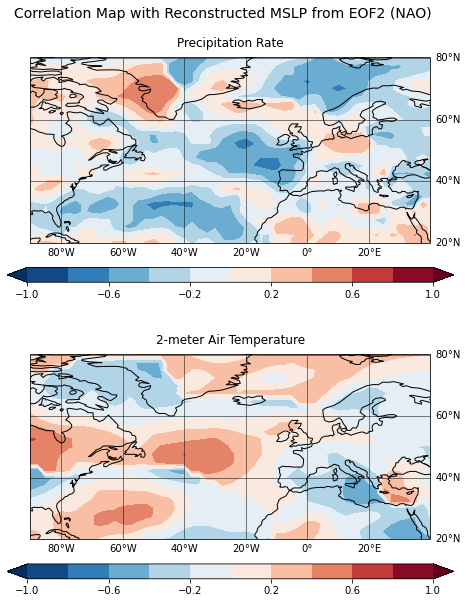

In [23]:
# plot the correlation maps

# preparing plots
corrmaps = [corrmap_prec, corrmap_t2m]
nvar = len(corrmaps)
titles = ['Precipitation Rate', '2-meter Air Temperature']

fig = plt.figure(figsize=(8,10))
gs = fig.add_gridspec(nvar, 1)

fig.suptitle('Correlation Map with Reconstructed MSLP from EOF2 (NAO)', fontsize=14, y=0.95)

for k in range(nvar):
    ax = fig.add_subplot(gs[k,0], projection=projection)
    ax = plot_background(ax)
    ax.set_extent([loni1-360, loni2, lati1-12, lati2])
    corrmaps[k], lon01 = add_cyclic_point(corrmaps[k], lon0)
    cf = ax.contourf(lon01, lat0, corrmaps[k], levels=levels, cmap=cmap, transform=crs, extend='both')
    ax = plot_grid(ax)
    cb = fig.colorbar(cf, ax=ax, location='bottom', orientation='horizontal', shrink=1, pad=0.1, aspect=30, ticks=cf.levels[::2])
    ax.set_title(titles[k], fontsize=12)

plt.show()

Positive (negative) correlations indicate positive (negative) covariability of the field with the magnitude of the NAO. For example, the negative correlations found over the Labrador Sea for the 2-meter temperature show that the positive phase of the NAO is associated with cooler temperatures over this region. Overall, it is clear that the NAO has a broad influence on surface climate conditions over some parts of North America and Europe, which motivates its skillful prediction. 

It is worth noting that the expected impacts differ from what we observe in the plot above. For instance, it is well known that the positive phase of the NAO is associated with warmer and wetter conditions over North Europe, which contradicts our findings. There could be several reasons for these discrepancies, one of which being the choice of analysis domain. It is likely that the choice of a larger domain over the North Atlantic contributed to a weak NAO signal superimposed on other modes. 